In [46]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error, r2_score
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.base import clone

# helpfunctions

In [47]:
class CustomBoost(object):
    def __init__(self, base_estimator=None, n_estimators=10000, rit_alpha=1 - 1e-10, max_depth=5, max_leaf_nodes=2**5, nu=1):
        self.n_estimators = n_estimators
        self.rit_alpha = rit_alpha
        self.max_depth = max_depth
        self.max_leaf_nodes = max_leaf_nodes
        self.nu = nu
        self.base_estimator = MyDecisionTreeRegressor(random_state=0,
                                                max_depth=max_depth,
                                                max_leaf_nodes=max_leaf_nodes,
                                                rit_alpha=rit_alpha)
        if base_estimator:
            self.base_estimator = base_estimator

        self.estimators_ = [clone(self.base_estimator) for _ in range(self.n_estimators)]

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators,
                'rit_alpha': self.rit_alpha,
                'max_depth': self.max_depth,
                'max_leaf_nodes': self.max_leaf_nodes,
                'nu': self.nu,
                'base_estimator': self.base_estimator}
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    def fit(self, X, y):
        f = np.zeros_like(y)
        for clf in self.estimators_:
            clf.fit(X, y-f)
            f=f+clf.predict(X) * self.nu
    def predict(self, X):
        b = [self.nu * clf.predict(X) for clf in self.estimators_]
        return np.sum(b, axis=0)

In [48]:
def separate_cb_reg(cb):
    trees = cb.estimators_
    trees_0 = [tree for tree in trees if (0 in tree.tree_.feature) and (1 not in tree.tree_.feature)]
    trees_1 = [tree for tree in trees if (1 in tree.tree_.feature) and (0 not in tree.tree_.feature)]

    model_0 = CustomBoost(n_estimators=len(trees_0), rit_alpha=cb.rit_alpha, max_depth=cb.max_depth, nu=cb.nu)
    model_0.estimators_ = trees_0
    model_1 = CustomBoost(n_estimators=len(trees_1), rit_alpha=cb.rit_alpha, max_depth=cb.max_depth, nu=cb.nu)
    model_1.estimators_ = trees_1
    return model_0, model_1

In [49]:
def hypothesis_check(rf, X_test, y_test):
    rf_0, rf_1 = separate_cb_reg(rf)

    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['lines.markersize'] = 6
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['axes.titlesize'] = 36
    plt.rcParams['axes.labelsize'] = 18
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.rcParams['font.size'] = 50

    fig = plt.figure()
    gs = gridspec.GridSpec(2, 2)

    subs = []
    for sub in gs:
        subs.append(fig.add_subplot(sub))
    subs = np.array(subs).reshape(2, 2)

    x0 = X_test.transpose(1,0)[0]
    x1 = X_test.transpose(1,0)[1]
    y0_rf = rf_0.predict(X_test)
    y0_pr = x0
    y1_rf = rf_1.predict(X_test)
    y1_pr = x1

    subplotNames = ['Feature 0', 'Feature 1', 'Features', 'Features']

    for i, ax in enumerate(subs.flat):
        ax.annotate(
            text=subplotNames[i], 
            xy=(0.5, 1.05),
            xycoords='axes fraction',
            ha='center',
            fontsize=24
        )
        
        if i == 0:
            ax.set_xlabel('X0')
            ax.scatter(x0, y0_rf, 0.3, 'b', label='predicted')
            ax.scatter(x0, y0_pr, 0.3, 'r', label='hypothesis, y = x')
        if i == 1:
            ax.set_xlabel('X1')
            ax.scatter(x1, y1_rf, 0.3, 'r', label='predicted')
            ax.scatter(x1, y1_pr, 0.3, 'b', label='hypothesis, y = x')
        if i == 2:
            ax.set_xlabel('X1 * X2')
            ax.scatter(x0 * x1, y0_rf * y1_rf, 0.3, 'r', label='hypothesis, y = y1 * y2')
            ax.scatter(x0 * x1, x0 + x1, 0.3, 'b', label='y = x')
        if i == 3:
            ax.set_xlabel('X1 * X2')
            ax.scatter(x0 * x1, rf.predict(X_test), 0.3, 'r', label='predicted')
            ax.scatter(x0 * x1, x0 * x1, 0.3, 'b', label='y = x')
        
        # Настройка осей
        ax.set_ylabel('y')
        ax.legend()
    print("score = {}".format(r2_score(rf.predict(X_test), y_test)))
    print("Trees with feature 0: {}, trees with feature 1: {}, total trees: {}".format(len(rf_0.estimators_), len(rf_1.estimators_), len(rf.estimators_)))
    plt.tight_layout()
    plt.show()

In [50]:
def func_cb(X, y, alpha):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}
  clf = GridSearchCV(CustomBoost(rit_alpha=alpha),
                   params,
                   scoring = "r2", 
                   cv=[(np.arange(X_train.shape[0]), np.arange(0))])
  clf.fit(X_train, y_train)
  cb = clf.best_estimator_
  print("rit_alpha = {}, max_depth = {}, score = {}".format(cb.rit_alpha, cb.max_depth, r2_score(cb.predict(X_test), y_test)))
  return cb

# Выборки

In [51]:
def data_regression_2D_1():
  n = 2
  N = 4000

  X1 = np.random.random(N) - 0.5
  X2 = np.random.random(N) - 0.5

  y = X1 * X2 + np.random.random(N) / 5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [52]:
def data_regression_2D_5():
  n = 2
  N = 4000

  X1 = np.random.random(N) - 0.5
  X2 = np.random.random(N) - 0.5

  y = X1 + X2 + np.random.random(N) / 5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [53]:
def data_regression_2D_2():
  n = 2
  N = 4000

  X1 = np.random.randn(N) * 10
  X2 = np.random.randn(N) * 10

  y = X1 * X2 + np.random.randn(N)
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [54]:
def data_regression_2D_6():
  n = 2
  N = 4000

  X1 = np.random.randn(N) * 10
  X2 = np.random.randn(N) * 10

  y = X1 + X2 + np.random.randn(N)
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [55]:
def data_regression_2D_3():
  n = 2
  N = 4000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 * X2 + np.random.random(N) / 5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [56]:
def data_regression_2D_7():
  n = 2
  N = 4000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N) / 5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [57]:
def data_regression_2D_4():
  n = 2
  N = 4000

  X1 = np.random.randn(N) * 10 + 5
  X2 = np.random.randn(N) * 10 -10

  y = X1 * X2 + np.random.randn(N)
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [58]:
def data_regression_2D_8():
  n = 2
  N = 4000

  X1 = np.random.randn(N) * 10 + 5
  X2 = np.random.randn(N) * 10 -10

  y = X1 + X2 + np.random.randn(N)
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

# Проверка гипотез

## Boosting

In [68]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 50

### uniform, noncentered

In [ ]:
X, y = data_regression_2D_1()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_1 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_1.append(r2_score(cb.predict(X_test), y_test))

In [87]:
for i in range(len(arr_1)):
    print("rit_alpha = {}, score = {}".format(alphas[i], arr_1[i]))

rit_alpha = -10000, score = 0.34680412138092853
rit_alpha = 0, score = 0.34680412138092853
rit_alpha = 0.1, score = 0.3112576359966901
rit_alpha = 0.2, score = 0.34203670217077087
rit_alpha = 0.3, score = 0.3188302857096663
rit_alpha = 0.5, score = 0.3132627050629587
rit_alpha = 0.7, score = 0.33471616009337457
rit_alpha = 0.8, score = 0.32336518567940387
rit_alpha = 0.9, score = 0.2252432438619526
rit_alpha = 0.91, score = 0.2194326101753783
rit_alpha = 0.93, score = 0.21997748857916133
rit_alpha = 0.95, score = 0.22021991971620292
rit_alpha = 0.99, score = -0.07653364852039135
rit_alpha = 0.999, score = -1.1502116290642106
rit_alpha = 0.9999, score = -1.15020719856979
rit_alpha = 0.99999, score = -1.15020719856979
rit_alpha = 0.999999, score = -1.15020719856979


In [ ]:
X, y = data_regression_2D_5()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_5 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_5.append(r2_score(cb.predict(X_test), y_test))

In [88]:
for i in range(len(arr_5)):
    print("rit_alpha = {}, score = {}".format(alphas[i], arr_5[i]))

rit_alpha = -10000, score = 0.9511486567810503
rit_alpha = 0, score = 0.9511486567810503
rit_alpha = 0.1, score = 0.9530085402972885
rit_alpha = 0.2, score = 0.9490835450446045
rit_alpha = 0.3, score = 0.9509626165555574
rit_alpha = 0.5, score = 0.9498415013189802
rit_alpha = 0.7, score = 0.9471540114592769
rit_alpha = 0.8, score = 0.9473787016136421
rit_alpha = 0.9, score = 0.9358659235880187
rit_alpha = 0.91, score = 0.9324173618863476
rit_alpha = 0.93, score = 0.9256284982964713
rit_alpha = 0.95, score = 0.921573851442315
rit_alpha = 0.99, score = 0.9542398686427926
rit_alpha = 0.999, score = 0.9542398686427926
rit_alpha = 0.9999, score = 0.9542398686427926
rit_alpha = 0.99999, score = 0.9542398686427926
rit_alpha = 0.999999, score = 0.9542398686427926


### gauss, centered

In [ ]:
X, y = data_regression_2D_2()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_2 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_2.append(r2_score(cb.predict(X_test), y_test))

In [89]:
for i in range(len(arr_2)):
    print("rit_alpha = {}, score = {}".format(alphas[i], arr_2[i]))

rit_alpha = -10000, score = 0.9262511036074436
rit_alpha = 0, score = 0.9262511036074436
rit_alpha = 0.1, score = 0.933836645123399
rit_alpha = 0.2, score = 0.9048901558002447
rit_alpha = 0.3, score = 0.8584400748273417
rit_alpha = 0.5, score = 0.8751262727383811
rit_alpha = 0.7, score = 0.8243880376886025
rit_alpha = 0.8, score = 0.8169661788293369
rit_alpha = 0.9, score = 0.617455668042253
rit_alpha = 0.91, score = 0.6284826448923144
rit_alpha = 0.93, score = 0.8013514946797513
rit_alpha = 0.95, score = 0.7923318715521397
rit_alpha = 0.99, score = 0.3837664087468404
rit_alpha = 0.999, score = -0.9519948657397463
rit_alpha = 0.9999, score = -0.9519948657397463
rit_alpha = 0.99999, score = -0.9519948657397463
rit_alpha = 0.999999, score = -0.9519948657397463


In [ ]:
X, y = data_regression_2D_6()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_6 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_6.append(r2_score(cb.predict(X_test), y_test))

In [90]:
for i in range(len(arr_6)):
    print("rit_alpha = {}, score = {}".format(alphas[i], arr_6[i]))

rit_alpha = -10000, score = 0.972216014027468
rit_alpha = 0, score = 0.972216014027468
rit_alpha = 0.1, score = 0.9706384712772247
rit_alpha = 0.2, score = 0.9708161295760985
rit_alpha = 0.3, score = 0.9745206758978916
rit_alpha = 0.5, score = 0.9656261297419846
rit_alpha = 0.7, score = 0.9650637625519877
rit_alpha = 0.8, score = 0.9673565001302191
rit_alpha = 0.9, score = 0.9545533808639038
rit_alpha = 0.91, score = 0.9414552657074113
rit_alpha = 0.93, score = 0.942236000882637
rit_alpha = 0.95, score = 0.9275273535084237
rit_alpha = 0.99, score = 0.975410712248507
rit_alpha = 0.999, score = 0.975410712248507
rit_alpha = 0.9999, score = 0.975410712248507
rit_alpha = 0.99999, score = 0.975410712248507
rit_alpha = 0.999999, score = 0.975410712248507


### uniform, centered

In [ ]:
X, y = data_regression_2D_3()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_3 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_3.append(r2_score(cb.predict(X_test), y_test))

In [ ]:
for i in range(len(arr_3)):
    print("rit_alpha = {}, max_depth = {}, score = {}".format(alphas[i], arr_3[i]))

In [ ]:
X, y = data_regression_2D_7()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_7 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_7.append(r2_score(cb.predict(X_test), y_test))

In [ ]:
for i in range(len(arr_7)):
    print("rit_alpha = {}, max_depth = {}, score = {}".format(alphas[i], arr_7[i]))

### gauss, noncentered

In [ ]:
X, y = data_regression_2D_4()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_4 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_4.append(r2_score(cb.predict(X_test), y_test))

In [91]:
for i in range(len(arr_4)):
    print("rit_alpha = {}, score = {}".format(alphas[i], arr_4[i]))

rit_alpha = -10000, score = 0.9787410773729865
rit_alpha = 0, score = 0.9787410773729865
rit_alpha = 0.1, score = 0.982859419527683
rit_alpha = 0.2, score = 0.9820189808605356
rit_alpha = 0.3, score = 0.9796921129534444
rit_alpha = 0.5, score = 0.9800940584152968
rit_alpha = 0.7, score = 0.9488546880433677
rit_alpha = 0.8, score = 0.9576483824876117
rit_alpha = 0.9, score = 0.8852363022964934
rit_alpha = 0.91, score = 0.8944036113933569
rit_alpha = 0.93, score = 0.8597801158192454
rit_alpha = 0.95, score = 0.8366830566486814
rit_alpha = 0.99, score = 0.7994946932337644
rit_alpha = 0.999, score = 0.1757101800688754
rit_alpha = 0.9999, score = 0.1757101800688754
rit_alpha = 0.99999, score = 0.1757101800688754
rit_alpha = 0.999999, score = 0.1757101800688754


In [85]:
X, y = data_regression_2D_8()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 0.9999, 0.99999, 0.999999, 1]
arr_8 = []
for alpha in alphas[:-1]:
    cb = CustomBoost(rit_alpha=alpha)
    cb.fit(X_train, y_train)
    arr_8.append(r2_score(cb.predict(X_test), y_test))

In [92]:
for i in range(len(arr_8)):
    print("rit_alpha = {}, score = {}".format(alphas[i], arr_8[i]))

rit_alpha = -10000, score = 0.9781137737006044
rit_alpha = 0, score = 0.9781137737006044
rit_alpha = 0.1, score = 0.9795148568610131
rit_alpha = 0.2, score = 0.9748204904543636
rit_alpha = 0.3, score = 0.9748421589787678
rit_alpha = 0.5, score = 0.9738251810813163
rit_alpha = 0.7, score = 0.9681525769557253
rit_alpha = 0.8, score = 0.9582838833028018
rit_alpha = 0.9, score = 0.9624350084245218
rit_alpha = 0.91, score = 0.9526916772183769
rit_alpha = 0.93, score = 0.949853843737699
rit_alpha = 0.95, score = 0.9460845007202751
rit_alpha = 0.99, score = 0.9843899813040808
rit_alpha = 0.999, score = 0.9843899813040808
rit_alpha = 0.9999, score = 0.9843899813040808
rit_alpha = 0.99999, score = 0.9843899813040808
rit_alpha = 0.999999, score = 0.9843899813040808


### graphics

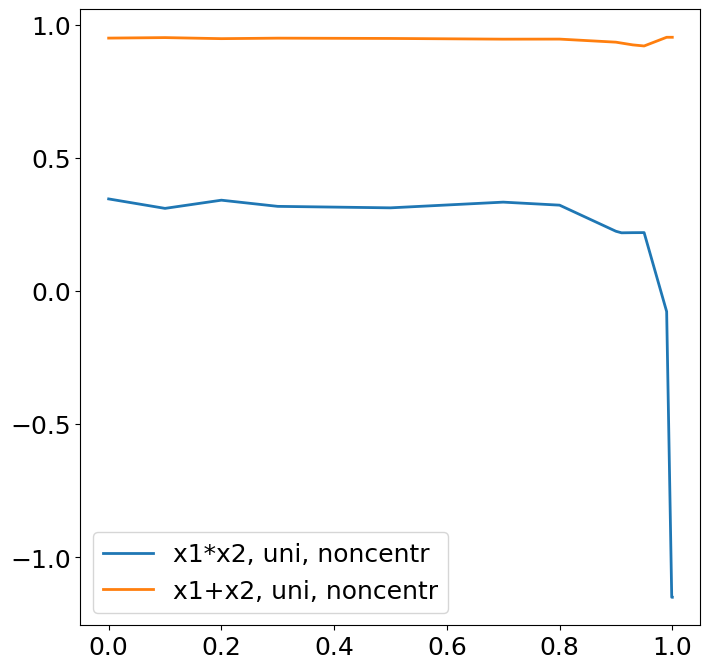

In [94]:
plt.plot(alphas[1:-1], arr_1[1:], label="x1*x2, uni, noncentr")
plt.plot(alphas[1:-1], arr_5[1:], label="x1+x2, uni, noncentr")
plt.legend()
plt.show()

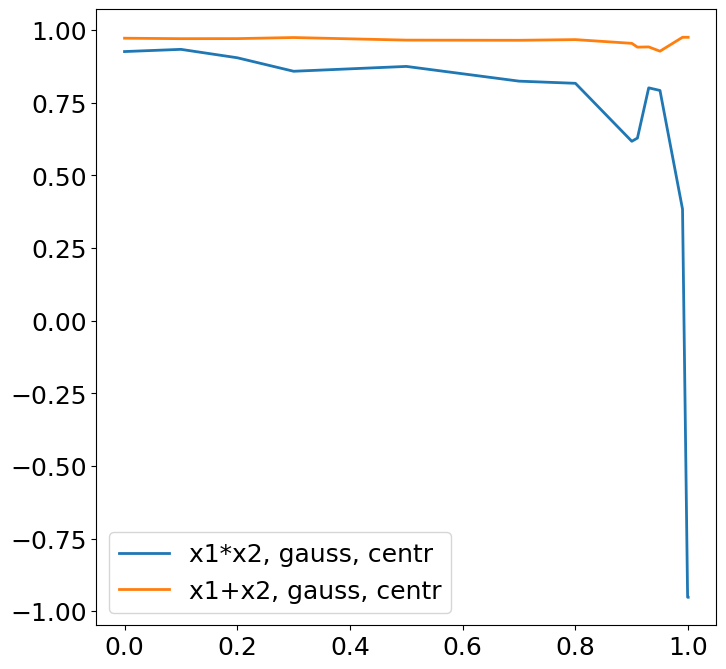

In [95]:
plt.plot(alphas[1:-1], arr_2[1:], label="x1*x2, gauss, centr")
plt.plot(alphas[1:-1], arr_6[1:], label="x1+x2, gauss, centr")
plt.legend()
plt.show()

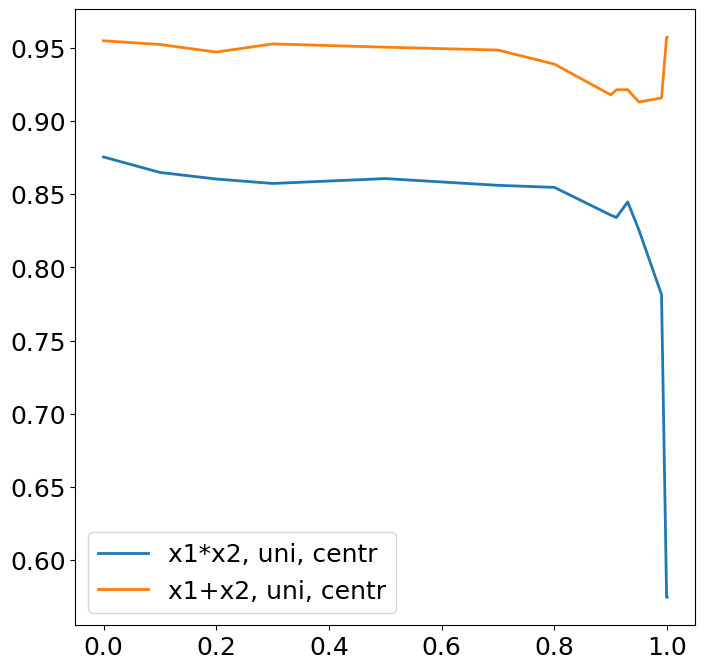

In [96]:
plt.plot(alphas[1:-1], arr_3[1:], label="x1*x2, uni, centr")
plt.plot(alphas[1:-1], arr_7[1:], label="x1+x2, uni, centr")
plt.legend()
plt.show()

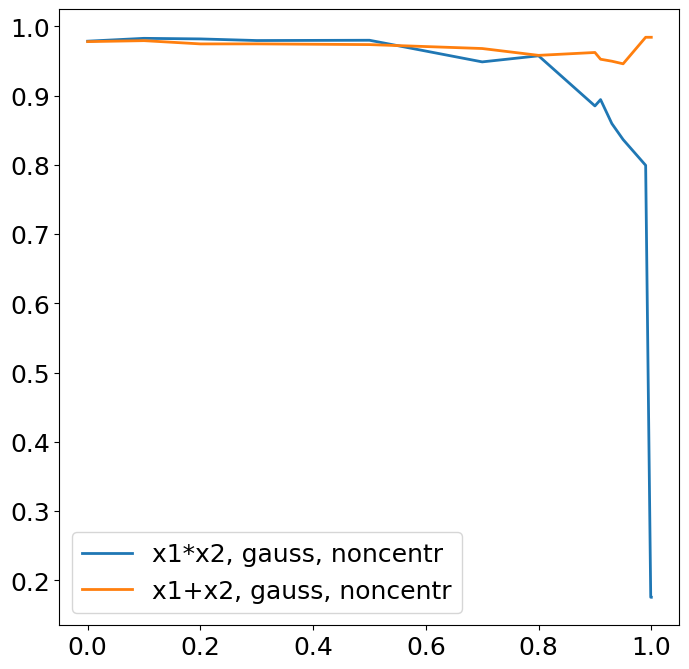

In [97]:
plt.plot(alphas[1:-1], arr_4[1:], label="x1*x2, gauss, noncentr")
plt.plot(alphas[1:-1], arr_8[1:], label="x1+x2, gauss, noncentr")
plt.legend()
plt.show()